<a href="https://colab.research.google.com/github/rdiazrincon/SLEAP_Data/blob/master/analysis/prediction_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for behavioral prediction of differences in dominant vs subordinate mice during reward competition 

### (Optional) Installing required packages

**Note:** If you are runnning this Notebook from Colab most packages will be already installed. But please do so if you are running locally.

In [1]:
# !pip install h5py
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas
# !pip install sklearn
# !pip install numpy
# !pip install scipy
# !pip install tables

### Importing packages

In [2]:
import h5py
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.interpolate import interp1d

### Getting the data from Github 

**Note:** Run this if you are using Colab. It will save the labeled data in your current directory.

In [3]:
# !wget -O prediction_analysis.h5 https://github.com/rdiazrincon/SLEAP_Data/blob/master/analysis/data/prediction_analysis.h5

### Setting up the paths for labeled data and reward competition info

In [4]:
path = "data/prediction_analysis.h5"
intervals = "data/WL_info_by_timestamp.csv"

## Exploring the data

In [5]:
# Opening the H5 file
with h5py.File(path, "r") as f:
    dataset_keys = list(f.keys())
    tracks = f["tracks"][:].T
    bodyparts = [n.decode() for n in f["node_names"][:]]

print(f"Filename:{path}")
print(f"Array keys{dataset_keys}:")
print(f"Behavioral data shape:{tracks.shape}")
print(f"Body parts{bodyparts}")

Filename:data/prediction_analysis.h5
Array keys['edge_inds', 'edge_names', 'instance_scores', 'node_names', 'point_scores', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks']:
Behavioral data shape:(54546, 6, 2, 2)
Body parts['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']


## Understanding the data 

We only work with the tracks array. It contains information regarding Number of Frames, Number of Bodyparts, Number of Coordinates and Number of instances.


In [6]:
# Here's what each dimension of the matrix's shape means
n_frames, n_bodyparts, n_coordinates, n_instances = tracks.shape

print(f"Number of Frames: {n_frames}")
print(f"Number of Bodyparts: {n_bodyparts}")
print(f"Number of Coordinates: {n_coordinates}")
print(f"NUmber of Instances: {n_instances}")

Number of Frames: 54546
Number of Bodyparts: 6
Number of Coordinates: 2
NUmber of Instances: 2


### Exploring (and making sense out of) the data

- The tracks array contains all of the information we need. 
- The first dimension of the array will provide us with information regarding the frames labeled in the video. 
- The second dimension relates to each body part (6 in our case). Note that, in the example below, we get data from the forehead by accesing position 5 in the array. 
- The third dimension relates to the X and Y coordinates and the fourth dimension to the number if animals/mice/instances


#### First frame 

In [7]:
print(tracks[0])

[[[184.44789124 315.60144043]
  [351.55776978 379.87524414]]

 [[140.21481323 284.03588867]
  [364.47213745 367.95025635]]

 [[183.75314331 319.75219727]
  [404.18869019 427.59402466]]

 [[147.53791809 412.41549683]
  [208.04371643 216.35691833]]

 [[148.6204834  339.65484619]
  [324.4312439  299.75323486]]

 [[168.43464661 296.26281738]
  [367.9828186  387.65563965]]]


#### Forehead coordinates for both mouse in Frame 1

**Note:** You can find the forehead data in position 5 of the tracks array. In general, the "bodyparts" array contains information regarding the position of bodyparts.
 

In [8]:
print(tracks[0][5])

[[168.43464661 296.26281738]
 [367.9828186  387.65563965]]


#### Forehead X-coordinate for both mouse in Frame 1

In [9]:
print(tracks[0][5][0])

[168.43464661 296.26281738]


#### Forehead Y-coordinate for mouse 2 in Frame 1.

In [10]:
print(tracks[0][5][0][1]) 

296.2628173828125


## Now let's mess around with the data ...

### Fill-in missing values

We won't drop the NaN values but will fill them with Non Zero values so the analysis is easier to make

In [11]:
def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

After filling out the NaN values with None Zero values, the array maintains the same shape

In [12]:
tracks = fill_missing(tracks)
print(tracks.shape)

(54546, 6, 2, 2)


### Reading and handling information related to Reward Competition

The information in the Frames column relates to the frames that make up a Trial. We will be reading a file to get this information


In [13]:
df_trials = pd.read_csv(intervals)['Frame']
df_trials

0       2100-2400
1       4470-4770
2       7140-7440
3       9510-9810
4     11730-12030
5     14670-14970
6     17520-17820
7     20160-20460
8     22530-22830
9     25200-25500
10    28140-28440
11    30840-31140
12    34410-34710
13    37050-37350
14    39570-39870
15    42210-42510
16    45030-45330
17    48600-48900
18    50970-51270
19    53790-54090
Name: Frame, dtype: object

### Converting the trials DataFrame to an array

Using the dash to separate each trial in an array

In [14]:
trials_array_separated = [trial.split("-") for trial in df_trials] # Returns a list of lists
print(trials_array_separated)

[['2100', '2400'], ['4470', '4770'], ['7140', '7440'], ['9510', '9810'], ['11730', '12030'], ['14670', '14970'], ['17520', '17820'], ['20160', '20460'], ['22530', '22830'], ['25200', '25500'], ['28140', '28440'], ['30840', '31140'], ['34410', '34710'], ['37050', '37350'], ['39570', '39870'], ['42210', '42510'], ['45030', '45330'], ['48600', '48900'], ['50970', '51270'], ['53790', '54090']]


Looping through the nested array, converting each (str) element to int and appending the elements in a new array 


In [15]:
trials_array = [int(j) for i in range(len(trials_array_separated)) for j in trials_array_separated[i]]
print(trials_array)

# Leaving this here for future reference
# for i in range(len(trials_array_separated)):
#     for j in trials_array_separated[i]:
#         trials_array.append(eval(j))
        
# trials_array

[2100, 2400, 4470, 4770, 7140, 7440, 9510, 9810, 11730, 12030, 14670, 14970, 17520, 17820, 20160, 20460, 22530, 22830, 25200, 25500, 28140, 28440, 30840, 31140, 34410, 34710, 37050, 37350, 39570, 39870, 42210, 42510, 45030, 45330, 48600, 48900, 50970, 51270, 53790, 54090]


## Getting information on mice coordinates based in trials 

For each body part, we loop through the set of frames that comprise a single trial. We repeat for all the trials in the competition (20).
Each video has 30 frames per second(fps) and each trial lasts 10 second.

In [16]:
LEFT_EAR_INDEX = 0
RIGHT_EAR_INDEX = 1
NOSE_INDEX = 2
TAIL_BASE_INDEX = 3
THORAX_INDEX = 4
FOREHEAD_INDEX = 5

n_trials = 20
fps = 30
trial_length_seconds = 10
time_window_seconds = 15

frames_per_trial = fps * trial_length_seconds
time_window_frames = fps * time_window_seconds

left_ear_loc_aux = []
right_ear_loc_aux = []
nose_loc_aux = []
tail_base_loc_aux = []
thorax_loc_aux = []
forehead_loc_aux = []

Using the onset information to target a different set of frames. Now we are looking at the frames that occur 30 seconds prior to the tone onset and 30 seconds before the tone onset. That is, we will be looking at time_window_frames frames before and after

In [17]:
it = iter(trials_array)
trials_array_onset = []
for i, j in zip(it, it):
    trials_array_onset.append(i - time_window_frames)
    trials_array_onset.append(j + time_window_frames)

In [18]:
print(trials_array_onset)     

[1650, 2850, 4020, 5220, 6690, 7890, 9060, 10260, 11280, 12480, 14220, 15420, 17070, 18270, 19710, 20910, 22080, 23280, 24750, 25950, 27690, 28890, 30390, 31590, 33960, 35160, 36600, 37800, 39120, 40320, 41760, 42960, 44580, 45780, 48150, 49350, 50520, 51720, 53340, 54540]


In [19]:
print(trials_array)     

[2100, 2400, 4470, 4770, 7140, 7440, 9510, 9810, 11730, 12030, 14670, 14970, 17520, 17820, 20160, 20460, 22530, 22830, 25200, 25500, 28140, 28440, 30840, 31140, 34410, 34710, 37050, 37350, 39570, 39870, 42210, 42510, 45030, 45330, 48600, 48900, 50970, 51270, 53790, 54090]


Using the trials_array to loop through the intervals (first_frame_in_trial:last_frame_in_trial) and fill the vector with the coordinates corresponding for both mice and their body parts  


In [20]:
iterator = iter(trials_array_onset)
for first_frame_in_trial, last_frame_in_trial in zip(iterator, iterator):
    # print(len(tracks[first_frame_in_trial:last_frame_in_trial, LEFT_EAR_INDEX, :, :]))
    left_ear_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, LEFT_EAR_INDEX, :, :])
    right_ear_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, RIGHT_EAR_INDEX, :, :])
    nose_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, NOSE_INDEX, :, :])
    tail_base_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, TAIL_BASE_INDEX, :, :])
    thorax_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, THORAX_INDEX, :, :])
    forehead_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, FOREHEAD_INDEX, :, :])

frames_in_trial = last_frame_in_trial - first_frame_in_trial

In [21]:
array_shape = np.asarray(left_ear_loc_aux, dtype=object).shape
print(f"Old shape: {array_shape}")
left_ear_loc = np.asarray(left_ear_loc_aux, dtype=object).reshape(n_trials * frames_in_trial , n_coordinates, n_instances)
print(f"New shape: {left_ear_loc.shape}")
right_ear_loc = np.asarray(right_ear_loc_aux, dtype=object).reshape(n_trials * frames_in_trial, n_coordinates, n_instances)
nose_loc = np.asarray(nose_loc_aux, dtype=object).reshape(n_trials * frames_in_trial, n_coordinates, n_instances)
tail_base_loc = np.asarray(tail_base_loc_aux, dtype=object).reshape(n_trials * frames_in_trial, n_coordinates, n_instances)
thorax_loc = np.asarray(thorax_loc_aux, dtype=object).reshape(n_trials * frames_in_trial, n_coordinates, n_instances)
forehead_loc = np.asarray(forehead_loc_aux, dtype=object).reshape(n_trials * frames_in_trial, n_coordinates, n_instances)

Old shape: (20, 1200, 2, 2)
New shape: (24000, 2, 2)


### Converting our data into a Tabular format

In [22]:
# There is definitely an easier way of doing this but I don't have the time now

bp = ['left_ear', 'right_ear', 'thorax', 'tail', 'nose']
coord = ['x', 'y']
for i in range(1):
    for j in range(1):
        df_bla = {
            'm{j}_{bp[{0}]}_{i}': left_ear_loc[:, i, j]
        }

df = pd.DataFrame({
    'm1_left_ear_x': left_ear_loc[:, 0, 0], 
    'm1_left_ear_y': left_ear_loc[:, 1, 0], 
    "m2_left_ear_x": left_ear_loc[:, 0, 1],
    "m2_left_ear_y": left_ear_loc[:, 1, 1],

    'm1_right_ear_x': right_ear_loc[:, 0, 0], 
    'm1_right_ear_y': right_ear_loc[:, 1, 0], 
    "m2_right_ear_x": right_ear_loc[:, 0, 1],
    "m2_right_ear_y": right_ear_loc[:, 1, 1],
    
    'm1_nose_x': nose_loc[:, 0, 0], 
    'm1_nose_y': nose_loc[:, 1, 0], 
    "m2_nose_x": nose_loc[:, 0, 1],
    "m2_nose_y": nose_loc[:, 1, 1],

    'm1_tail_base_x': tail_base_loc[:, 0, 0], 
    'm1_tail_base_y': tail_base_loc[:, 1, 0], 
    "m2_tail_base_x": tail_base_loc[:, 0, 1],
    "m2_tail_base_y": tail_base_loc[:, 1, 1],

    'm1_thorax_x': thorax_loc[:, 0, 0], 
    'm1_thorax_y': thorax_loc[:, 1, 0], 
    "m2_thorax_x": thorax_loc[:, 0, 1],
    "m2_thorax_y": thorax_loc[:, 1, 1],

    'm1_forehead_x': forehead_loc[:, 0, 0], 
    'm1_forehead_y': forehead_loc[:, 1, 0], 
    "m2_forehead_x": forehead_loc[:, 0, 1],
    "m2_forehead_y": forehead_loc[:, 1, 1],
    })
df

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
0,347.890289,316.49823,552.264404,236.391174,303.732544,343.525574,512.929914,280.614905,332.042297,387.682739,...,489.675885,325.718874,272.194611,296.181,578.550226,298.541272,331.732635,347.699707,572.148193,235.906601
1,347.838531,316.558167,560.189297,241.687761,300.654053,343.988464,469.516636,300.575396,332.04187,387.976654,...,496.141809,314.48801,272.336395,299.664307,577.416675,300.91485,331.703674,348.014648,560.254028,231.729752
2,347.910065,316.548615,568.11419,246.984348,303.796875,344.70639,426.103359,320.535886,335.681305,384.080444,...,502.607733,303.257146,272.314392,300.173889,576.283124,303.288428,331.934631,348.21106,555.931,230.217468
3,351.628845,315.46051,576.039083,252.280935,304.556152,339.6745,382.690081,340.496377,328.006104,383.579926,...,509.073657,292.026282,271.777252,296.035187,575.149573,305.662006,332.334259,339.915161,551.607971,228.705185
4,352.077881,311.908752,583.963976,257.577521,308.612488,336.490234,339.276803,360.456868,332.023132,352.524628,...,515.539581,280.795418,271.527802,292.011658,574.016022,308.035583,335.935577,332.35675,548.077393,231.80658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,323.378906,380.523254,431.611755,383.97287,276.622345,379.740417,399.454865,368.147064,311.998901,424.242126,...,431.780914,216.607819,284.232178,336.292542,432.220673,311.864105,303.723114,396.054901,407.690216,387.675476
23996,323.463074,380.456055,431.529358,384.187347,279.524414,379.70401,400.208771,368.140594,312.03067,424.311798,...,431.774658,219.646317,284.293335,336.324768,435.587067,308.511658,303.819946,396.088562,403.832001,387.679626
23997,323.514221,380.453705,431.992035,384.481171,279.571259,379.75235,403.75766,368.625702,312.061371,424.301239,...,431.954102,216.562195,284.350006,336.317688,435.989685,311.737488,303.863312,396.122894,379.918182,376.418457
23998,323.399231,380.398651,431.863586,387.534943,276.601868,379.78772,405.216838,369.73762,311.933197,424.14801,...,431.946564,216.540787,284.242279,336.406647,435.744995,311.906982,303.767273,396.184296,415.358612,384.574158


### Further exploration of the data

In [23]:
df.describe()

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
count,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.00000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
unique,23643.000000,23727.000000,23570.00000,23676.000000,23557.000000,23730.00000,23616.000000,23713.000000,23685.000000,23323.000000,...,23934.000000,23869.00000,23882.000000,23675.000000,23870.000000,23624.000000,23616.000000,23663.000000,23604.000000,23581.000000
top,323.596283,387.548615,319.73407,380.201385,283.650208,367.59024,280.438843,375.838654,324.202179,423.997192,...,276.412292,236.09314,284.063751,332.231201,295.804962,331.965302,300.347107,392.422241,299.961609,396.384277
freq,3.000000,3.000000,3.00000,3.000000,3.000000,3.00000,3.000000,3.000000,3.000000,4.000000,...,2.000000,2.00000,3.000000,3.000000,2.000000,3.000000,4.000000,3.000000,3.000000,3.000000


In [24]:
df.sample()

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
627,319.743896,359.644989,316.060211,283.607758,287.708618,396.400391,258.415344,322.510468,335.583069,399.753815,...,172.445526,239.679626,244.330948,355.815704,236.385178,268.315948,315.489838,384.367584,300.092072,300.141479


In [25]:
df.value_counts()

m1_left_ear_x  m1_left_ear_y  m2_left_ear_x  m2_left_ear_y  m1_right_ear_x  m1_right_ear_y  m2_right_ear_x  m2_right_ear_y  m1_nose_x   m1_nose_y   m2_nose_x   m2_nose_y   m1_tail_base_x  m1_tail_base_y  m2_tail_base_x  m2_tail_base_y  m1_thorax_x  m1_thorax_y  m2_thorax_x  m2_thorax_y  m1_forehead_x  m1_forehead_y  m2_forehead_x  m2_forehead_y
7.028120       244.329605     331.480713     352.264679     49.996193       233.598076      287.914917      372.347565      35.054666   197.124175  323.559143  423.611633  63.445561       183.071954      159.455139      264.194824      27.854786    275.418213   259.718567   312.415253   24.137610      224.237839     316.115784     376.150848       1
324.435852     387.635895     263.858307     364.084259     284.447021      368.148560      219.921341      392.581635      314.704163  413.605184  296.422882  416.001984  292.199127      228.433151      191.774918      204.358902      324.038849   315.822632   203.800476   323.685852   303.859619   

In [26]:
df2 = pd.read_csv(intervals)['Winner (1:M_1,0:M_2,2:Tie)']
df2

0     1
1     2
2     0
3     1
4     2
5     2
6     2
7     0
8     2
9     2
10    1
11    2
12    1
13    0
14    0
15    0
16    2
17    2
18    2
19    0
Name: Winner (1:M_1,0:M_2,2:Tie), dtype: int64

In [27]:
features_array = df2.to_numpy().repeat(frames_in_trial)
print(features_array.shape)

(24000,)


### Running Random Forest for prediction

In [28]:
X = df
Y = features_array

In [29]:
X.shape

(24000, 24)

In [30]:
Y.shape

(24000,)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

In [32]:
model = RandomForestClassifier(n_estimators = 10, random_state = 30)

In [33]:
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=30)

In [34]:
df_see_frames = X_test.index
df_see_frames

Int64Index([ 3360, 18845, 22058,  8102,  4927,  3424,  4692, 11400,   406,
            10244,
            ...
             3925,  3867,  4042, 12694,  9450, 18255, 18712,  6372, 15329,
            19449],
           dtype='int64', length=4800)

In [35]:
prediction_test = model.predict(X_test)
prediction_test

array([0, 0, 2, ..., 2, 1, 2])

In [36]:
prediction_probability = model.predict_proba(X_test)
prediction_probability

array([[0.7, 0. , 0.3],
       [0.7, 0. , 0.3],
       [0.1, 0. , 0.9],
       ...,
       [0.2, 0.1, 0.7],
       [0.1, 0.5, 0.4],
       [0. , 0. , 1. ]])

In [37]:
print (f"Accuracy: {metrics.accuracy_score(y_test, prediction_test):.2f}")

Accuracy: 0.96


In [38]:
print(model.score(X_test, y_test))

0.9622916666666667


In [39]:
X_test

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
3360,228.105695,325.747931,311.430756,336.289032,191.641897,394.620468,284.42572,383.841888,262.372478,387.242742,...,91.635376,275.897858,208.20752,276.43396,215.785019,316.019806,218.648193,387.342126,312.072632,368.447723
18845,293.964366,289.332616,319.75946,355.845154,249.561474,412.382953,283.563782,391.941162,281.642741,322.85493,...,171.827484,232.092697,169.733806,314.608034,260.082458,332.052948,278.082062,305.882904,311.913483,380.232178
22058,247.791855,59.842258,316.082428,384.369843,299.494568,63.564854,276.351105,367.677307,267.855865,40.352409,...,332.201477,208.561142,268.389526,111.781624,296.021454,307.766296,271.619904,60.089184,292.42215,388.430359
8102,291.342438,352.21463,315.913208,339.799072,272.163971,408.215485,268.22934,327.854309,328.313629,391.531067,...,360.343262,199.603195,227.529846,352.190918,307.638794,280.203003,295.770752,384.237091,287.791016,340.113342
4927,620.369019,343.607849,299.829071,412.084106,600.0495,399.473022,267.726196,383.564026,630.803284,380.440125,...,319.539124,231.791183,551.505249,355.390442,307.415344,332.421326,624.027222,376.038635,280.154633,403.416534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18255,468.323486,275.659149,323.912201,380.626678,452.290558,332.225616,279.771515,375.719666,508.057983,312.155212,...,243.812531,232.366486,408.111603,283.494598,291.572632,328.069153,471.827576,304.537048,303.503082,395.51178
18712,211.42955,367.7742,324.373291,368.087555,180.102905,396.533844,283.658356,388.295258,256.331085,400.225555,...,227.65831,232.455276,155.620758,315.825043,251.738922,312.068451,207.416351,391.895996,312.130554,391.548279
6372,396.354279,364.507629,319.61731,376.133911,407.841125,308.493866,268.588501,383.695557,364.072845,323.434723,...,247.636856,228.079071,451.585236,344.082062,275.918457,336.057251,391.908661,336.318756,300.177887,392.140411
15329,328.133484,360.403137,379.901611,260.565765,296.493378,403.876404,375.714508,311.796814,335.543274,419.807434,...,207.838486,255.808167,275.532379,356.292328,303.617188,272.371185,324.242004,392.49054,383.482056,284.59729


In [40]:
confusion_matrix_table = pd.DataFrame({"Frame": df_see_frames, "Predicted Class Label": np.array(prediction_test), "Actual Class Label": np.array(y_test),})
confusion_matrix_table = confusion_matrix_table.sort_values(by='Frame', ascending=True)
print(confusion_matrix_table.to_string())

      Frame  Predicted Class Label  Actual Class Label
4544      1                      1                   1
455      13                      1                   1
4221     20                      1                   1
2081     25                      1                   1
3287     28                      1                   1
1461     32                      1                   1
4729     35                      1                   1
318      36                      1                   1
1695     45                      1                   1
1440     52                      1                   1
653      54                      1                   1
1219     55                      1                   1
2131     60                      1                   1
2438     66                      1                   1
1307     67                      1                   1
1283     70                      1                   1
2271     79                      1                   1
2994     8

In [41]:
feature_list = list(X.columns)
feature_list

['m1_left_ear_x',
 'm1_left_ear_y',
 'm2_left_ear_x',
 'm2_left_ear_y',
 'm1_right_ear_x',
 'm1_right_ear_y',
 'm2_right_ear_x',
 'm2_right_ear_y',
 'm1_nose_x',
 'm1_nose_y',
 'm2_nose_x',
 'm2_nose_y',
 'm1_tail_base_x',
 'm1_tail_base_y',
 'm2_tail_base_x',
 'm2_tail_base_y',
 'm1_thorax_x',
 'm1_thorax_y',
 'm2_thorax_x',
 'm2_thorax_y',
 'm1_forehead_x',
 'm1_forehead_y',
 'm2_forehead_x',
 'm2_forehead_y']

In [42]:
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp

m2_tail_base_x    0.088530
m2_tail_base_y    0.072406
m1_tail_base_x    0.070591
m2_thorax_x       0.066668
m1_tail_base_y    0.058999
m1_thorax_x       0.050414
m2_nose_x         0.042450
m2_forehead_x     0.042159
m2_right_ear_x    0.040971
m2_left_ear_y     0.039489
m2_thorax_y       0.037008
m2_left_ear_x     0.036777
m1_left_ear_y     0.036407
m1_nose_x         0.032717
m1_thorax_y       0.031096
m1_left_ear_x     0.030647
m2_forehead_y     0.029929
m1_right_ear_x    0.029491
m2_nose_y         0.029284
m1_forehead_x     0.028773
m1_right_ear_y    0.026829
m1_forehead_y     0.026546
m2_right_ear_y    0.026301
m1_nose_y         0.025520
dtype: float64

## Plotting the Confusion Matrix

[Text(0.5, 4.5, 'Predicted Labels'),
 Text(72.90000000000006, 0.5, 'True Labels')]

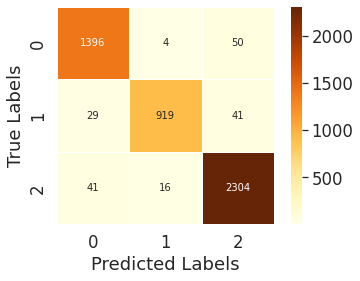

In [43]:
cm = confusion_matrix(y_test, prediction_test)
sns.set(rc={'figure.figsize':(10,10)}, font_scale=1.5)
plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlOrBr", fmt='d')
plot.set(xlabel='Predicted Labels', ylabel='True Labels')

In [44]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

Text(0.5, 1.0, 'Nose tracks across frames')

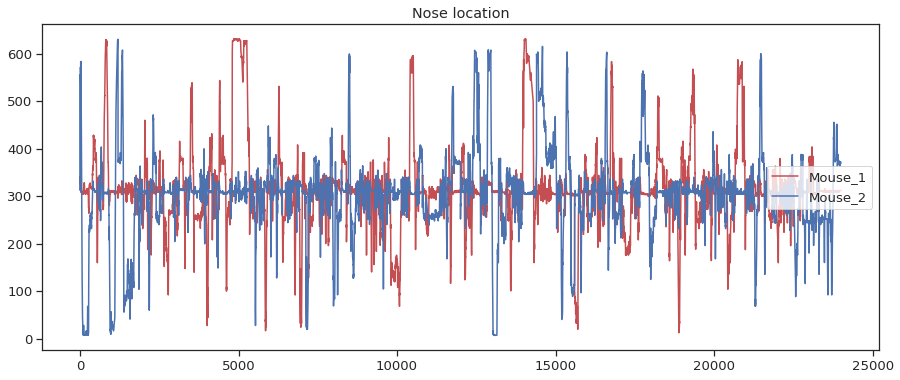

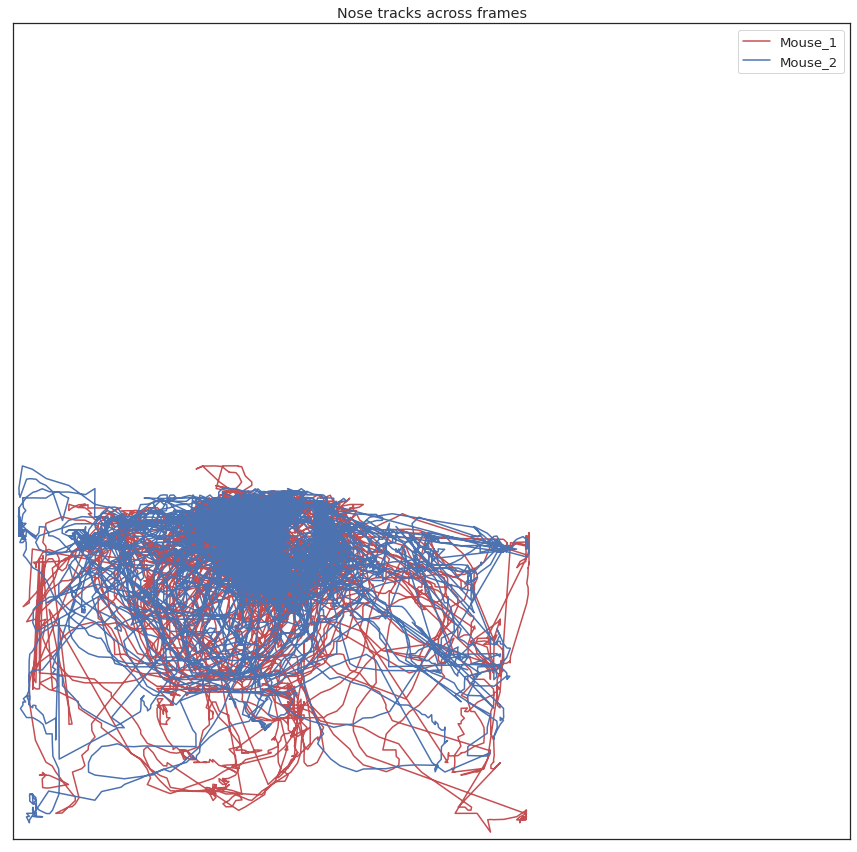

In [45]:
# Figure 1
plt.figure()

plt.plot(nose_loc[:,0,0], 'r',label='Mouse_1')
plt.plot(nose_loc[:,0,1], 'b',label='Mouse_2')
# plt.plot(-1*nose_loc[:,1,0], 'r')
# plt.plot(-1*nose_loc[:,1,1], 'b')

plt.legend(loc="center right")

plt.title('Nose location')

# Figure 2
plt.figure(figsize=(15,15))

plt.plot(nose_loc[:,0,0],nose_loc[:,1,0], 'r',label='Mouse_1')
plt.plot(nose_loc[:,0,1],nose_loc[:,1,1], 'b',label='Mouse_2')
plt.legend()

plt.xlim(0,1024)
plt.xticks([])

plt.ylim(0,1024)
plt.yticks([])
plt.title('Nose tracks across frames')

## More advanced visualizations (In Progress)

For some additional analysis, we'll first smooth and differentiate the data with a Savitzky-Golay filter to extract velocities of each joint.

In [46]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

There are two mice. Let's get results for each separately.

In [47]:
thx_vel_mouse1 = smooth_diff(nose_loc[:, :, 0].astype('float64'))
thx_vel_mouse2 = smooth_diff(nose_loc[:, :, 1].astype('float64'))

### Visualizing thorax x-y dynamics and velocity for Mouse_1

Text(0.5, 1.0, 'Velocity')

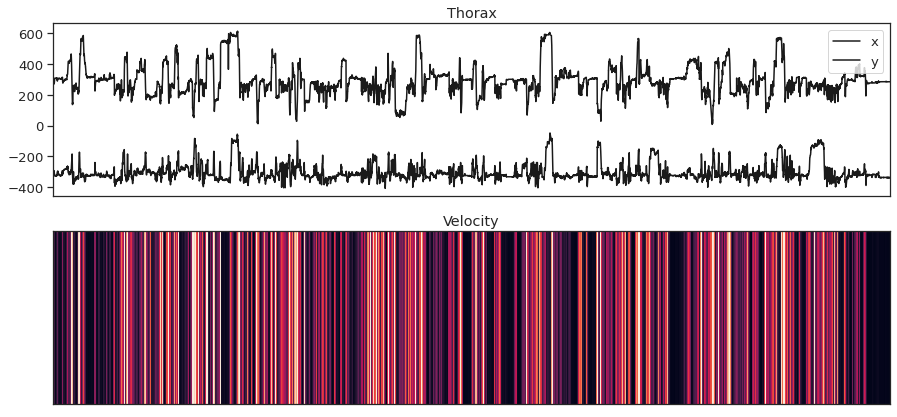

In [48]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thorax_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*thorax_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Thorax')

ax2 = fig.add_subplot(212, sharex=ax1)
# Using the Transpose of the Matrix
ax2.imshow(thx_vel_mouse1[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

### Visualize thorax colored by magnitude of Mouse speed

Text(0.5, 1.0, 'Thorax tracks colored by magnitude of Mouse speed')

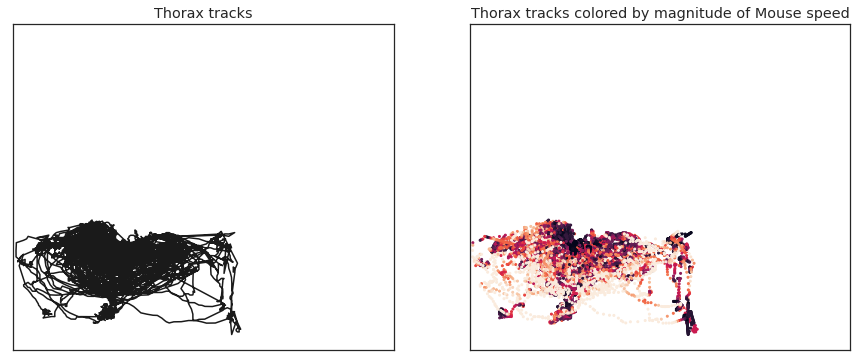

In [49]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(thorax_loc[:, 0, 0], thorax_loc[:, 1, 0], 'k')
ax1.set_xlim(0,1024)
ax1.set_xticks([])
ax1.set_ylim(0,1024)
ax1.set_yticks([])
ax1.set_title('Thorax tracks')

kp = thx_vel_mouse1 
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(thorax_loc[:,0,0], thorax_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)
ax2.set_xlim(0,1024)
ax2.set_xticks([])
ax2.set_ylim(0,1024)
ax2.set_yticks([])
ax2.set_title('Thorax tracks colored by magnitude of Mouse speed')

### Find covariance in thorax velocities between Mouse_1 and Mouse_2

In [50]:
def corr_roll(datax, datay, win):
    """
    datax, datay are the two timeseries to find correlations between
    
    win sets the number of frames over which the covariance is computed
    
    """
    
    s1 = pd.Series(datax)
    s2 = pd.Series(datay)
    
    return np.array(s2.rolling(win).corr(s1))

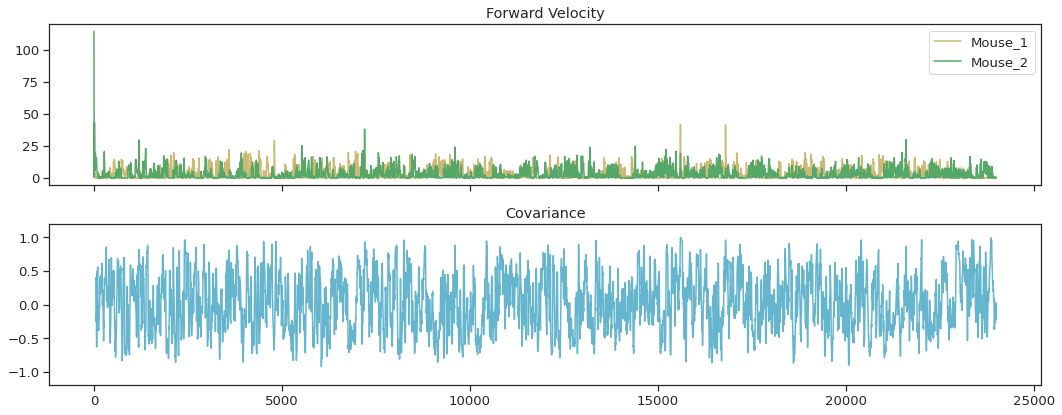

In [51]:
win = 50

cov_vel = corr_roll(thx_vel_mouse1, thx_vel_mouse2,win)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))
ax[0].plot(thx_vel_mouse1, 'y', label='Mouse_1')
ax[0].plot(thx_vel_mouse2, 'g', label='Mouse_2')
ax[0].legend()
ax[0].set_title('Forward Velocity')

ax[1].plot(cov_vel, 'c', markersize=1)
ax[1].set_ylim(-1.2, 1.2)
ax[1].set_title('Covariance')

fig.tight_layout()

### Todo:
- Use frame rate (30) to correlate have an intuition of which set of frames correspond to which minute/second in the video

## Clustering

For an example of clustering the data, we'll

1. extract joint velocities for each joint,
2. run k-means on the velocities from each frame.


In [52]:
def instance_node_velocities(instance_idx):
    mouse_node_tracks = tracks[:, :, :, instance_idx]
    mouse_node_velocities = np.zeros((n_frames, n_bodyparts))

    for n in range(0, n_bodyparts):
        mouse_node_velocities[:, n] = smooth_diff(mouse_node_tracks[:, n, :])
    
    return mouse_node_velocities

In [53]:
def plot_instance_node_velocities(instance_idx, node_velocities):
    plt.figure(figsize=(20,8))
    plt.imshow(node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
    plt.xlabel('frames')
    plt.ylabel('nodes')
    plt.yticks(np.arange(n_bodyparts), bodyparts, rotation=20);
    plt.title(f'Mouse {instance_idx} node velocities')

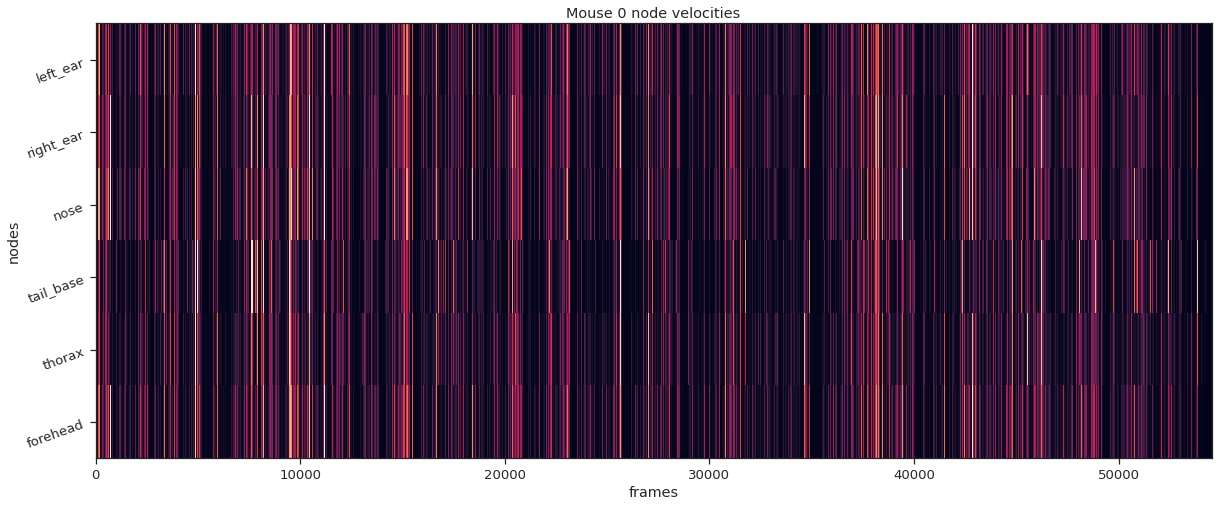

In [54]:
mouse_ID = 0
mouse_node_velocities = instance_node_velocities(mouse_ID)
plot_instance_node_velocities(mouse_ID, mouse_node_velocities)

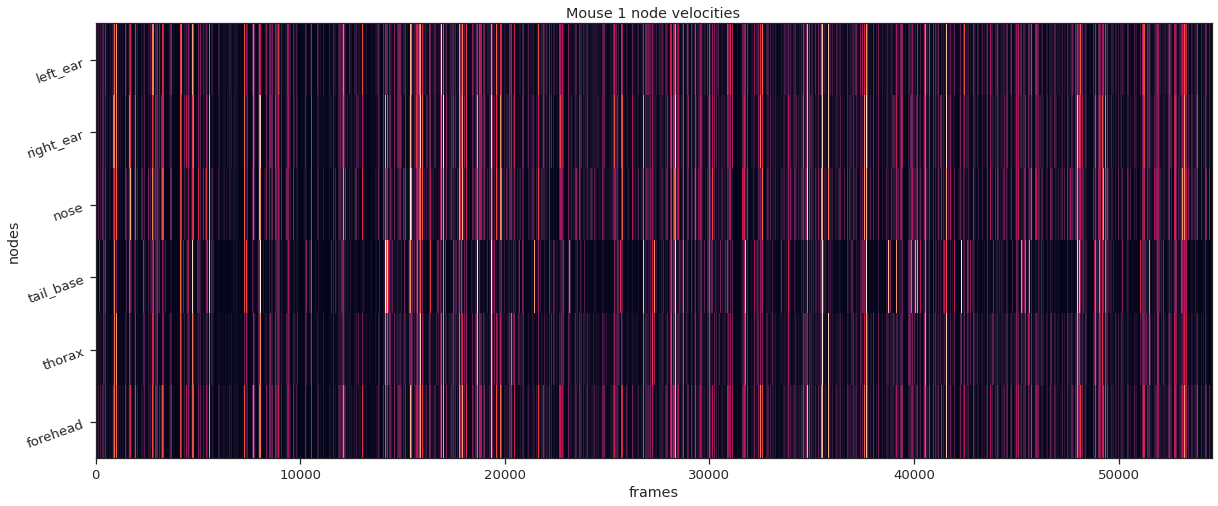

In [55]:
mouse_ID = 1
mouse_node_velocities = instance_node_velocities(mouse_ID)
plot_instance_node_velocities(mouse_ID, mouse_node_velocities)

In [56]:
from sklearn.cluster import KMeans

In [57]:
nstates = 10

km = KMeans(n_clusters=nstates)

labels = km.fit_predict(mouse_node_velocities)

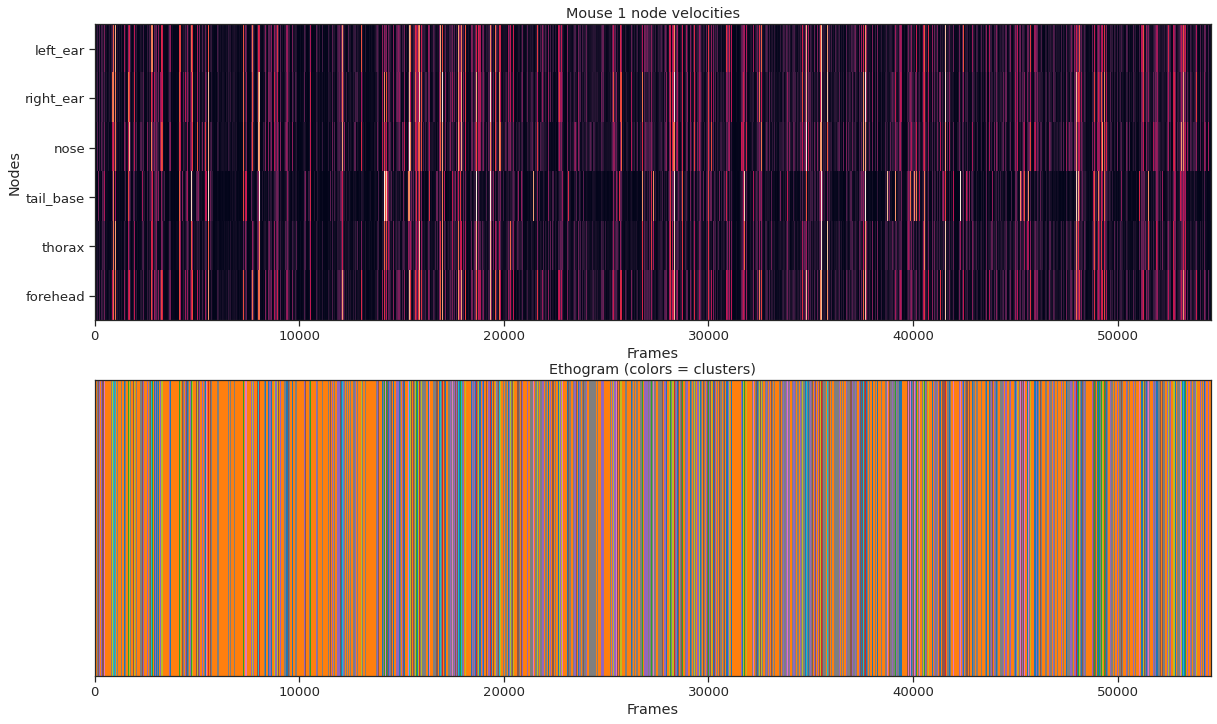

In [58]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(211)
ax1.imshow(mouse_node_velocities.T, aspect="auto", vmin=0, vmax=20, interpolation="nearest")
ax1.set_xlabel("Frames")
ax1.set_ylabel("Nodes")
ax1.set_yticks(np.arange(n_bodyparts))
ax1.set_yticklabels(bodyparts);
ax1.set_title(f"Mouse {mouse_ID} node velocities")
ax1.set_xlim(0,n_frames)

ax2 = fig.add_subplot(212,sharex=ax1)
ax2.imshow(labels[None, :], aspect="auto", cmap="tab10", interpolation="nearest")
ax2.set_xlabel("Frames")
ax2.set_yticks([])
ax2.set_title("Ethogram (colors = clusters)");